In [30]:
import json
import os
import sys

import cv2
import matplotlib.pyplot as plt
from matplotlib import animation
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tensorflow import keras
from tensorflow.keras import layers
from tqdm.notebook import tqdm

sys.path.append('../')
from scripts.get_s2_data_ee import get_history, get_history_polygon, get_pixel_vectors

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Sentinel 2 band descriptions
band_descriptions = {
    'B1': 'Aerosols, 442nm',
    'B2': 'Blue, 492nm',
    'B3': 'Green, 559nm',
    'B4': 'Red, 665nm',
    'B5': 'Red Edge 1, 704nm',
    'B6': 'Red Edge 2, 739nm',
    'B7': 'Red Edge 3, 779nm',
    'B8': 'NIR, 833nm',
    'B8A': 'Red Edge 4, 864nm',
    'B9': 'Water Vapor, 943nm',
    'B11': 'SWIR 1, 1610nm',
    'B12': 'SWIR 2, 2186nm'
}

## Test the network on candidate sites

In [203]:
# Positive site coordinates
import pandas as pd
candidate_sites = pd.read_csv('../data/model_outputs/candidate_sites/v12_java_candidates_0.4_threshold.csv')
candidate_coords = [[lon, lat] for lat, lon in zip(list(candidate_sites['lat']), list(candidate_sites['lon']))]
candidate_names = ['candidate_' + str(index) for index in range(len(candidate_coords))]
print(len(candidate_names))

805


In [409]:
#num_sites = 10
#coords = np.array(candidate_coords)[np.random.randint(0, len(candidate_coords), num_sites)]
coords = candidate_coords[:]
names = candidate_names[:]
rect_width = 0.004
start_date = '2020-06-01'
java = get_history(coords, 
                   names, 
                   rect_width,
                   num_months = 3,
                   start_date = start_date)

dates = list(java.keys())
sites = list(java[dates[0]].keys())

  0%|          | 0/3 [00:00<?, ?it/s]

 33%|███▎      | 1/3 [32:38<1:05:17, 1958.95s/it]

 67%|██████▋   | 2/3 [1:09:03<33:46, 2026.78s/it]

100%|██████████| 3/3 [2:38:15<00:00, 3165.21s/it]


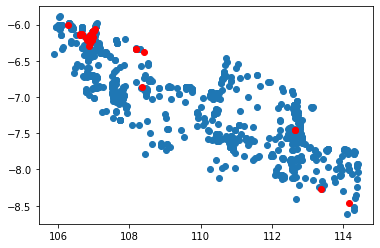

In [411]:
no_clouds = []
clouds = []

for site, coords in zip(sites, candidate_coords):
    if np.median([java[date][site]['B2'] for date in dates]) > 0:
        no_clouds.append(coords)
    else:
        clouds.append(coords)
        
plt.scatter([coord[0] for coord in no_clouds], [coord[1] for coord in no_clouds])
plt.scatter([coord[0] for coord in clouds], [coord[1] for coord in clouds], c='r')
plt.show()

In [412]:
print(f"{sum([1 for site in java[dates[0]] if np.median(java[dates[0]][site]['B2']) > 0]) / len(sites):.0%} percent of sites have cloud-free data")

86% percent of sites have cloud-free data


In [413]:
def normalize(x):
    return (np.array(x)) / (3000)

model = keras.models.load_model('../models/2d_java_classifier_0.004_patch.h5')

candidate_0 0.992144


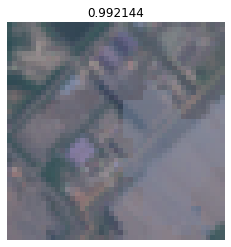

candidate_25 0.74845344


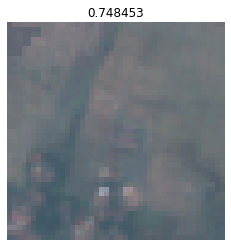

candidate_26 0.86592877


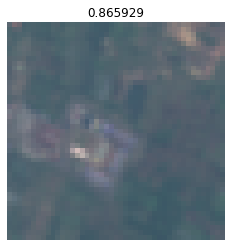

candidate_36 0.7405215


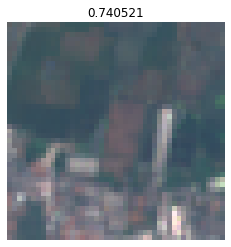

candidate_39 0.5354128


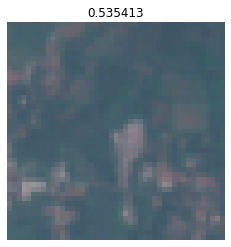

candidate_44 0.9946878


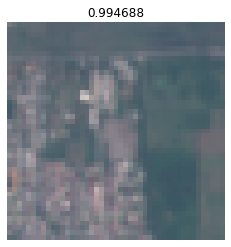

candidate_51 0.99941766


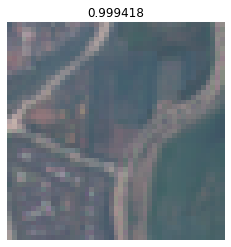

candidate_60 0.89629406


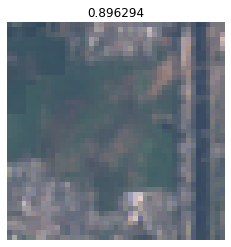

candidate_83 0.8542234


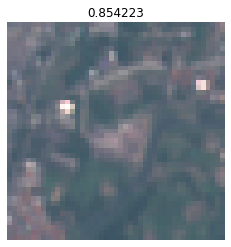

candidate_103 0.99996495


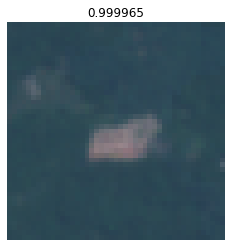

candidate_104 0.9970894


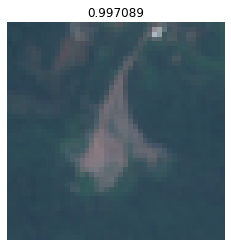

candidate_105 0.5293328


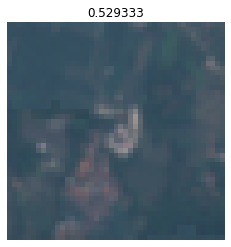

candidate_110 0.9250835


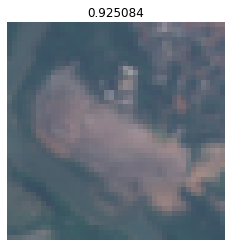

candidate_117 0.2809735


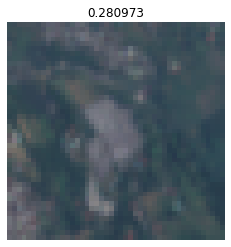

candidate_119 0.96507704


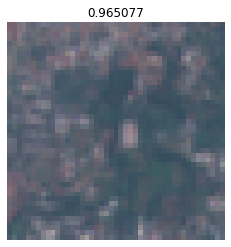

candidate_120 0.6364073


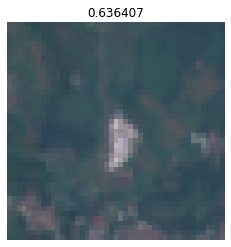

candidate_122 0.99916947


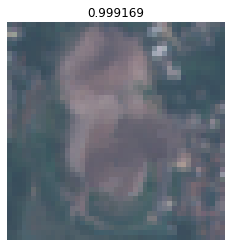

candidate_124 0.98863006


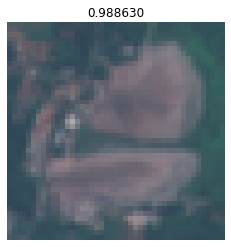

candidate_127 0.8568267


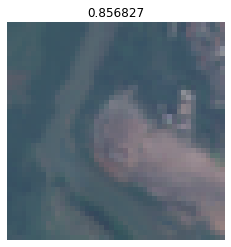

candidate_130 0.925776


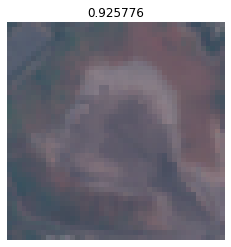

candidate_133 0.600152


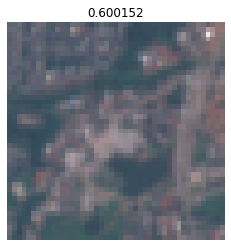

candidate_136 0.8473038


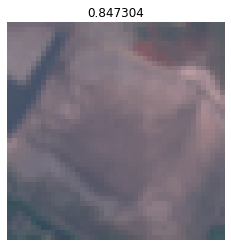

candidate_137 0.99529743


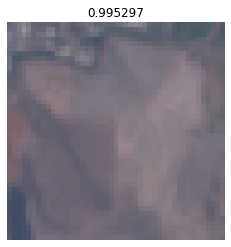

candidate_142 0.94928885


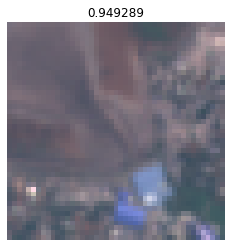

candidate_143 0.9930737


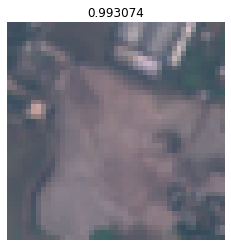

candidate_146 0.6923506


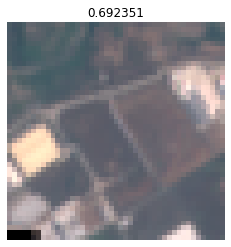

candidate_148 0.9770585


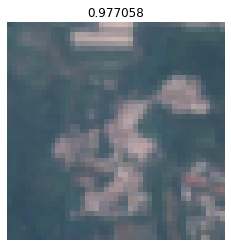

candidate_150 0.9927738


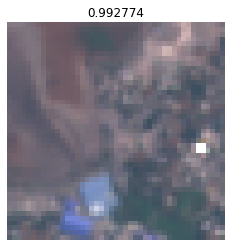

candidate_154 0.99890566


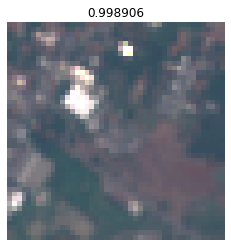

candidate_159 0.24777657


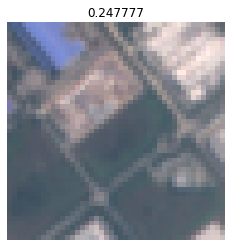

candidate_161 0.5858933


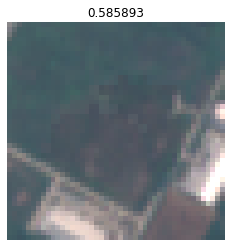

candidate_163 0.9980544


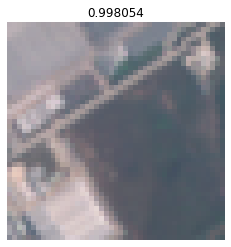

candidate_166 0.99958175


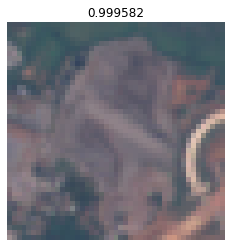

candidate_173 0.9999547


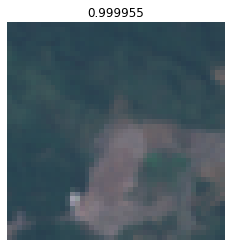

candidate_189 0.9771931


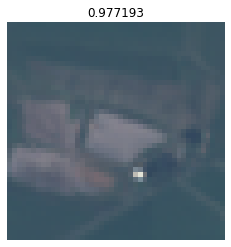

candidate_190 0.99412286


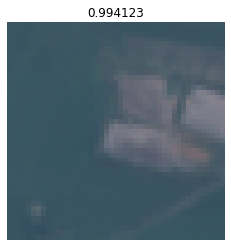

candidate_197 0.9942186


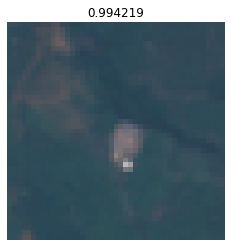

candidate_198 0.9956489


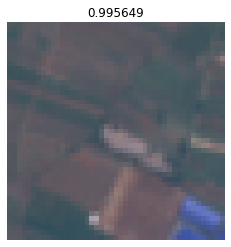

candidate_209 0.3563077


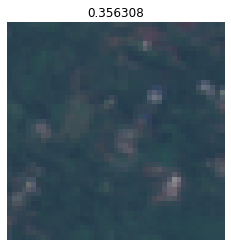

candidate_211 0.9064617


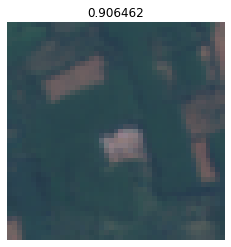

candidate_223 0.53912836


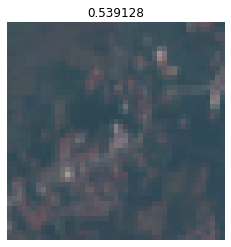

candidate_226 0.999742


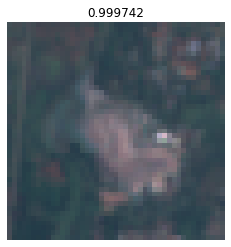

candidate_308 0.3664954


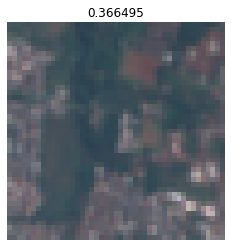

candidate_335 0.99994946


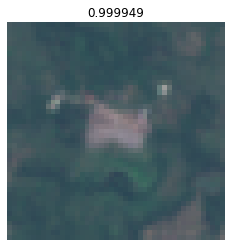

candidate_339 0.99542725


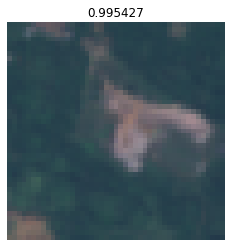

candidate_340 0.99915284


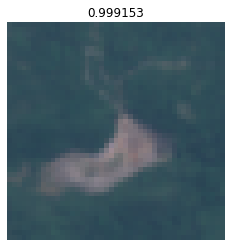

candidate_341 0.9974112


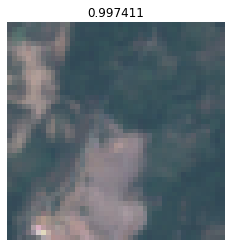

candidate_344 0.5100139


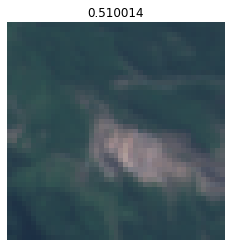

candidate_347 0.9998361


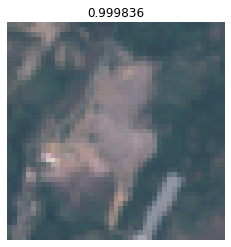

candidate_353 0.93919134


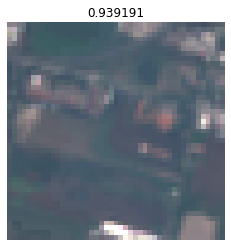

candidate_360 0.99998605


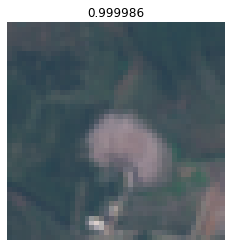

candidate_363 0.99919933


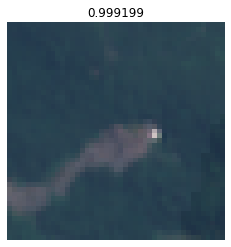

candidate_366 0.99999297


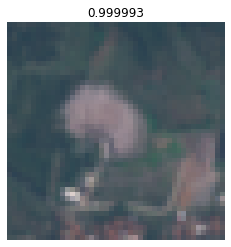

candidate_370 0.99933904


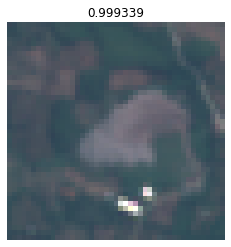

candidate_374 0.9997501


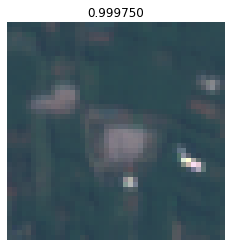

candidate_377 0.48965627


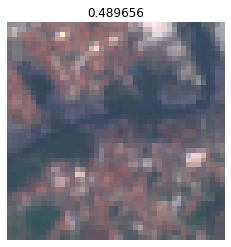

candidate_385 0.9999902


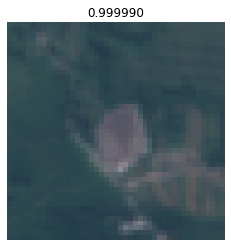

candidate_389 0.99982613


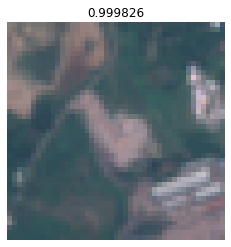

candidate_403 0.9029573


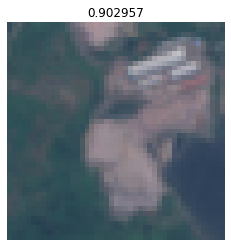

candidate_414 0.9979956


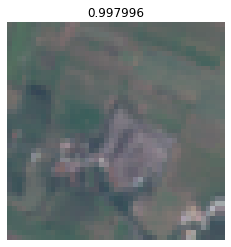

candidate_419 0.58237517


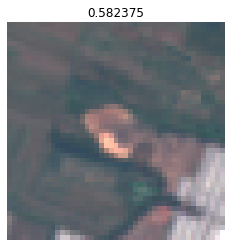

candidate_426 0.99987197


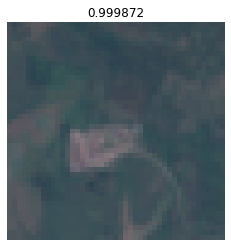

candidate_427 0.8681351


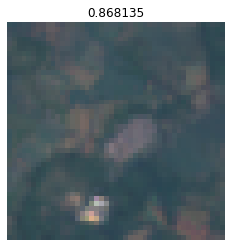

candidate_431 0.9933828


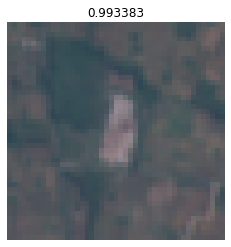

candidate_435 0.7698825


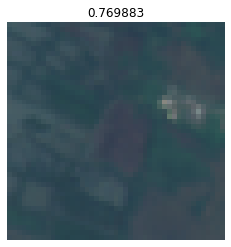

candidate_440 0.37296695


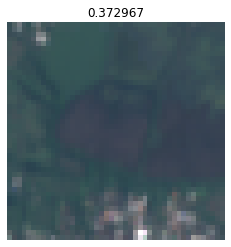

candidate_444 0.31354505


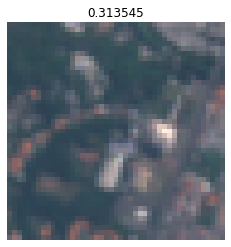

candidate_450 0.80172956


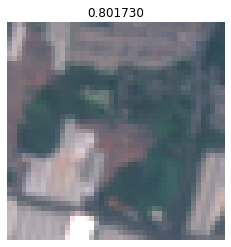

candidate_451 0.858277


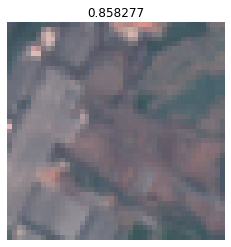

candidate_452 0.99995387


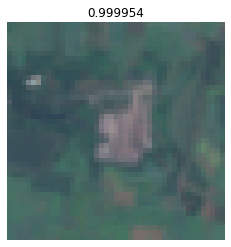

candidate_453 0.7942104


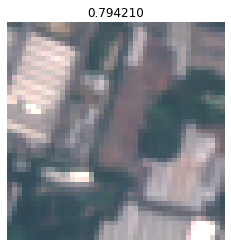

candidate_455 0.99833614


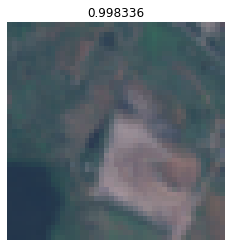

candidate_462 0.9423387


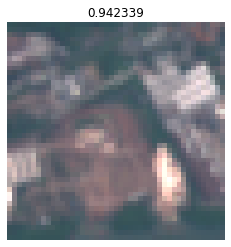

candidate_481 0.6904327


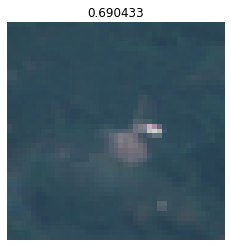

candidate_483 0.8694573


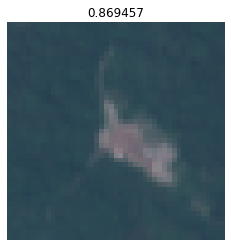

candidate_484 0.5788023


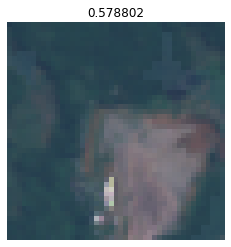

candidate_485 0.99820924


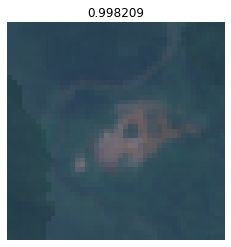

candidate_486 0.99868196


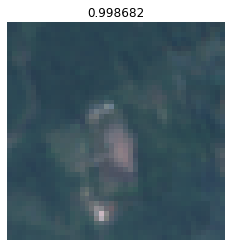

candidate_487 0.9998084


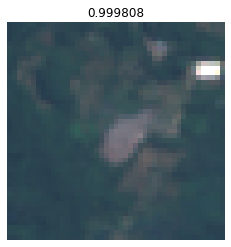

candidate_489 0.9952258


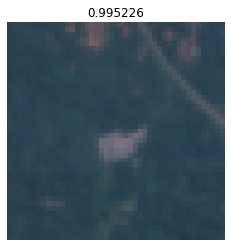

candidate_491 0.96899086


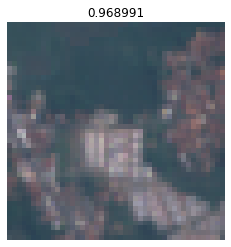

candidate_493 0.9999931


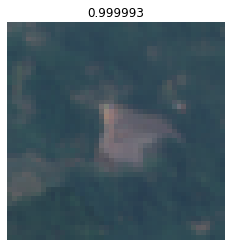

candidate_497 0.37195015


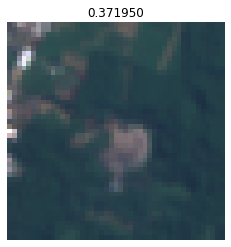

candidate_499 0.601414


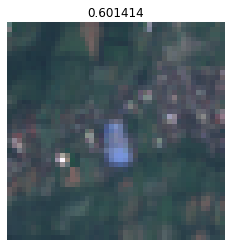

candidate_502 0.99878806


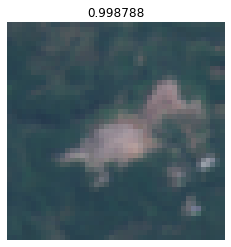

candidate_515 0.2328759


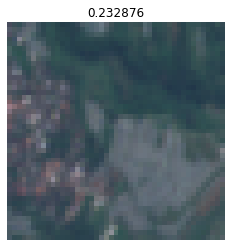

candidate_522 0.9996551


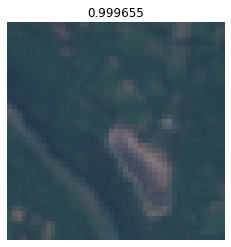

candidate_523 0.9990615


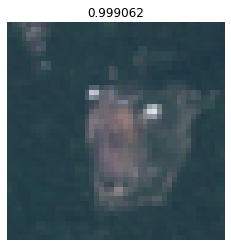

candidate_524 0.9558713


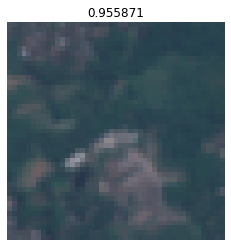

candidate_528 0.9999243


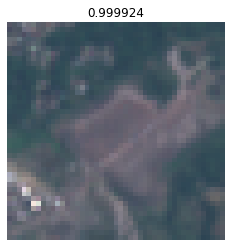

candidate_533 0.41788074


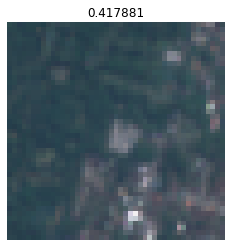

candidate_535 0.9942417


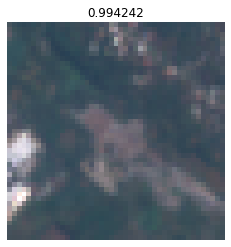

candidate_536 0.9950294


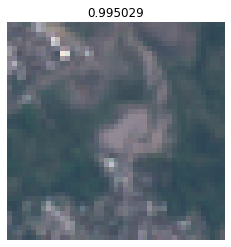

candidate_551 0.9805741


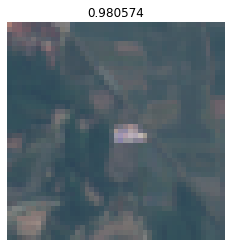

candidate_560 0.7993924


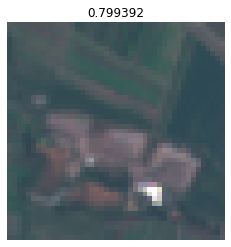

candidate_564 0.99993885


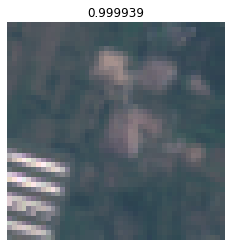

candidate_567 0.6597188


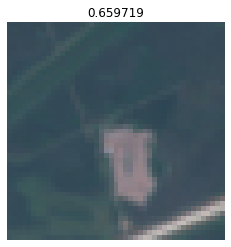

candidate_571 0.9978515


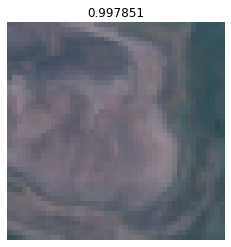

candidate_596 0.9932683


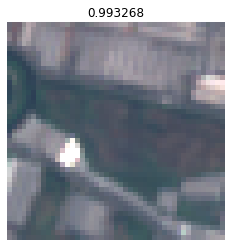

candidate_604 0.8810073


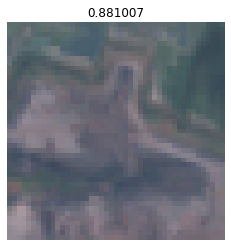

candidate_607 0.9416832


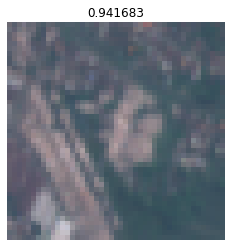

candidate_616 0.98671395


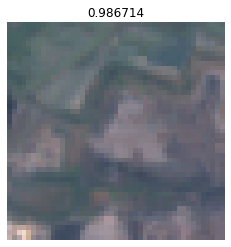

candidate_622 0.9962519


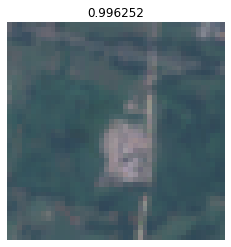

candidate_625 0.9498178


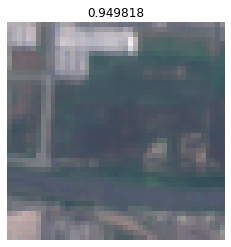

candidate_643 0.72842705


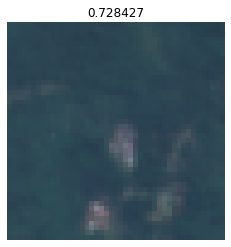

candidate_645 0.99616253


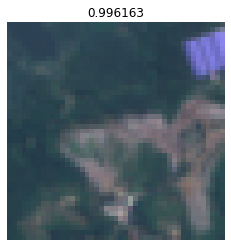

candidate_646 0.82456845


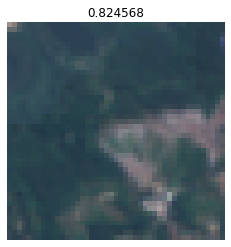

candidate_647 0.31699613


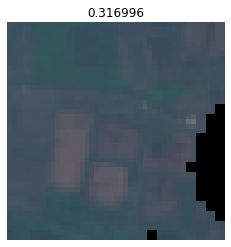

candidate_652 0.996664


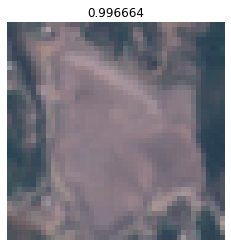

candidate_653 0.9959586


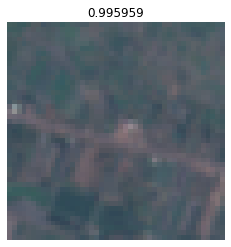

candidate_656 0.9995896


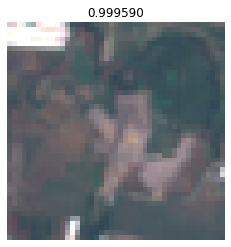

candidate_665 0.9988422


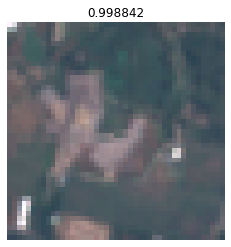

candidate_667 0.8479103


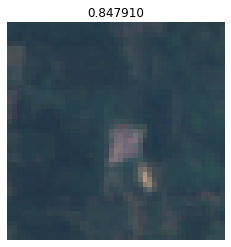

candidate_671 0.99929476


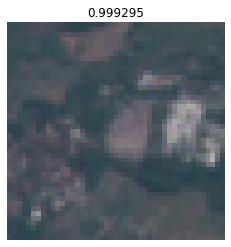

candidate_678 0.9382848


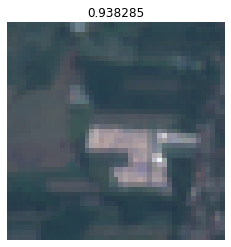

candidate_682 0.40438354


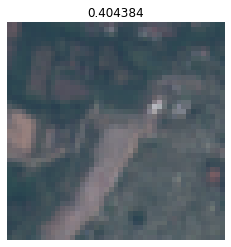

candidate_683 0.9934378


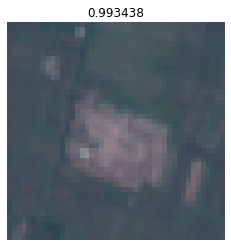

candidate_689 0.3038361


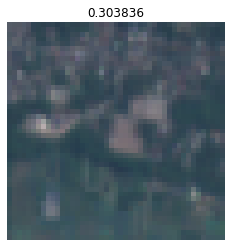

candidate_690 0.2899959


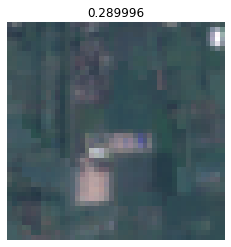

candidate_692 0.9744426


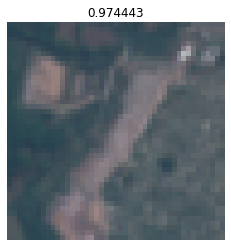

candidate_693 0.9975197


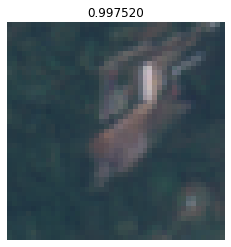

candidate_694 0.59151834


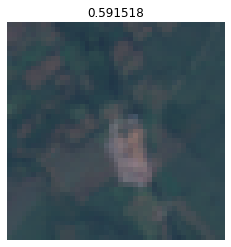

candidate_696 0.23358777


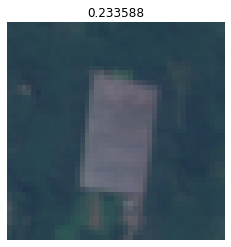

candidate_698 0.99800986


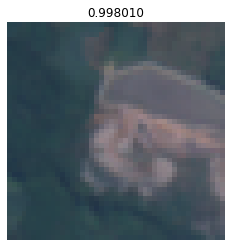

candidate_705 0.4543134


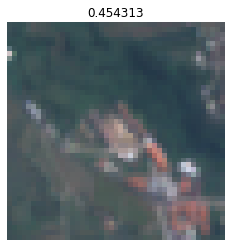

candidate_708 0.5749298


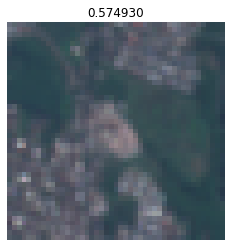

candidate_712 0.9990214


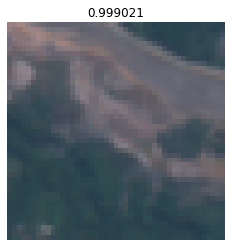

candidate_715 0.92991406


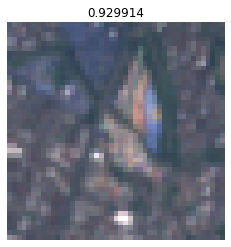

candidate_717 0.9709572


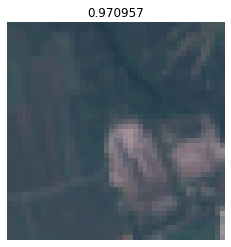

candidate_724 0.28555456


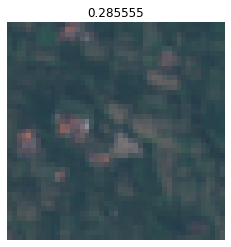

candidate_726 0.9976392


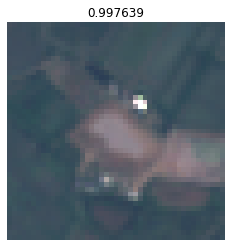

candidate_728 0.4914923


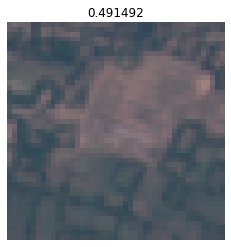

candidate_733 0.99176425


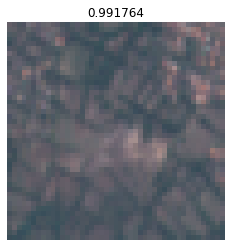

candidate_748 0.9106199


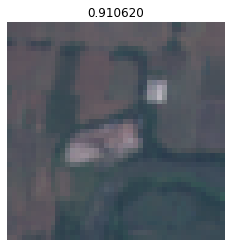

candidate_749 0.99974614


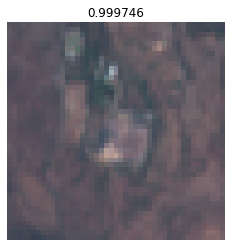

candidate_750 0.4992624


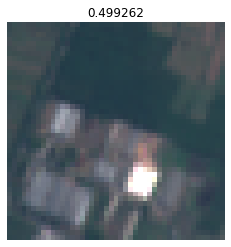

candidate_753 0.2547537


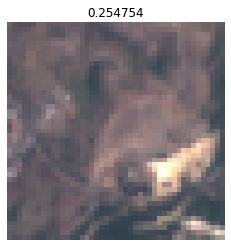

candidate_754 0.8918717


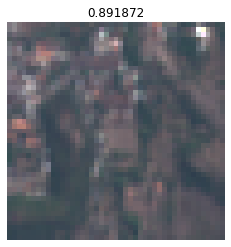

candidate_771 0.44645387


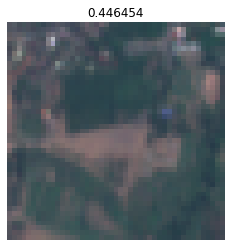

candidate_778 0.26684877


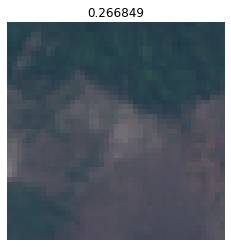

candidate_781 0.99987745


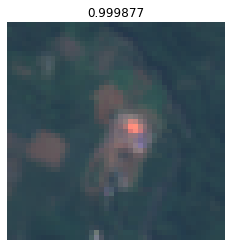

candidate_795 0.9893153


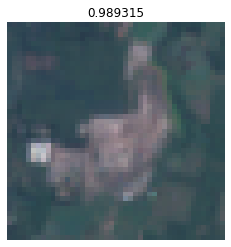

candidate_797 0.71830153


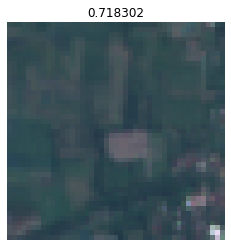

candidate_799 0.28382063


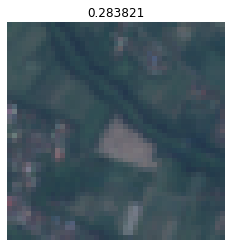

In [414]:
test_dataset = java
#dates = list(test_dataset.keys())
#sites = list(test_dataset[dates[0]].keys())

threshold = 0.2
all_preds = []
filtered_candidates = []
for index, site in enumerate(sites):
    preds = []
    rgb_stack = []
    for date in dates:
        img = []
        band_shapes = [np.shape(test_dataset[date][site][band]) for band in band_descriptions]
        if np.array(band_shapes).all() > 0:
            for band in band_descriptions:
                img.append(normalize(test_dataset[date][site][band]))
            img = np.rollaxis(np.array(img), 0, 3)
            img = img[:model.input_shape[1], :model.input_shape[2], :]
            if np.median(img) > 0:
                rgb = np.stack((img[:,:,3], img[:,:,2], img[:,:,1]), axis=-1)
                rgb_stack.append(rgb)
                preds.append(model.predict(np.expand_dims(img, 0))[0][1])
    if len(preds) > 0:
        all_preds.append([candidate_coords[index][1], candidate_coords[index][0], np.mean(preds)])
        if np.median(preds) > threshold:
            print(site, np.median(preds))
            filtered_candidates.append([candidate_coords[index][1], candidate_coords[index][0], np.median(preds)])
            #if candidate_coords[index] in confirmed_coords:
            #    print("confirmed")
            plt.imshow(np.clip(np.median(rgb_stack, axis=0), 0, 1))
            plt.axis('off')
            plt.title(f"{np.median(preds):2f}")
            plt.show()

In [330]:
print(len(filtered_candidates))

171


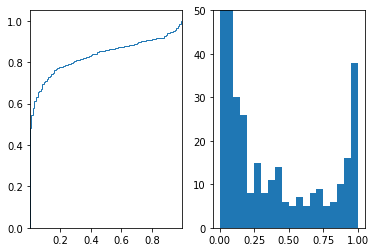

In [367]:
all_preds_df = pd.DataFrame(all_preds, columns=['lat', 'lon', 'pred'])
plt.subplot(1,2,1)
plt.hist(all_preds_df['pred'], bins=100, cumulative=True, density=True, histtype='step')
plt.xlim([0.001, 0.999])

plt.subplot(1,2,2)
plt.hist(all_preds_df['pred'], bins=20, density=False, histtype='bar')
#plt.xlim([0.001, 0.999])
plt.ylim([0, 50])
plt.show()

In [335]:
pd.DataFrame(all_preds, columns=['lat', 'lon', 'pred']).to_csv('../data/model_outputs/candidate_sites/v12_java_0.4_threshold_2D_0.004_patch.csv', 
                                                               float_format='%.5f')

In [322]:
pd.DataFrame(filtered_candidates, columns=['lat', 'lon', 'pred']).to_csv('../data/model_outputs/candidate_sites/v12_java_0.4_threshold_2D_filtered_0.004_patch.csv')

## Test model on Sri Lanka Sites

In [390]:
# Positive site coordinates
with open('../data/model_outputs/candidate_sites/sri_lanka_validated.geojson', 'r') as f:
    sri_lanka_geojson = json.load(f)

sri_lanka_coords = []
for site in sri_lanka_geojson['features']:
    lon = np.mean([coordinate[0] for coordinate in site['geometry']['coordinates'][0]])
    lat = np.mean([coordinate[1] for coordinate in site['geometry']['coordinates'][0]])
    sri_lanka_coords.append([lon, lat])
    
sri_lanka_names = ['sl_' + str(index) for index in range(len(candidate_coords))]

In [398]:
rect_width = 0.004
start_date = '2020-07-01'
sri_lanka_data = get_history(sri_lanka_coords, 
                             sri_lanka_names, 
                             rect_width,
                             num_months = 6,
                             start_date = start_date)

sri_lanka_dates = list(sri_lanka_data.keys())
sri_lanka_sites = list(sri_lanka_data[dates[0]].keys())

  0%|          | 0/6 [00:00<?, ?it/s]

 17%|█▋        | 1/6 [02:18<11:34, 138.84s/it]

 33%|███▎      | 2/6 [04:48<09:28, 142.19s/it]

 50%|█████     | 3/6 [07:35<07:28, 149.63s/it]

 67%|██████▋   | 4/6 [10:03<04:57, 148.94s/it]

 83%|████████▎ | 5/6 [13:00<02:37, 157.48s/it]

100%|██████████| 6/6 [17:16<00:00, 172.77s/it]


[2.2270955e-07, 0.0018751401, 3.660741e-06]


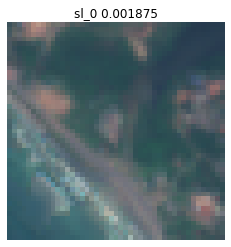

[0.9916441, 0.9996457, 0.9990761]


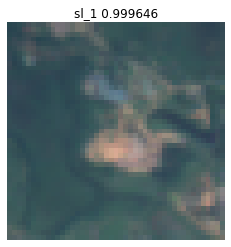

[0.62915987, 0.66948664, 0.9824218, 0.58131444]


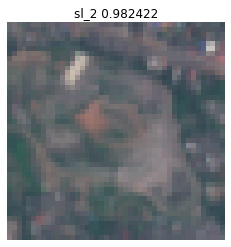

[0.6075639, 0.4532621, 0.7064716, 0.31298926]


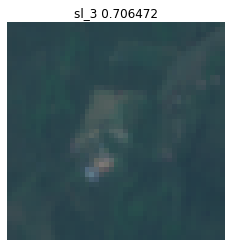

[0.1652258, 0.99980384, 0.9979704, 0.9980171, 0.9961265]


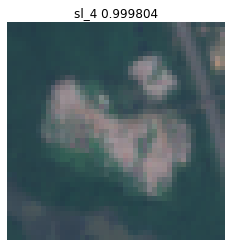

[0.35087442, 0.61876714, 0.010916358, 0.29277351, 0.7177238]


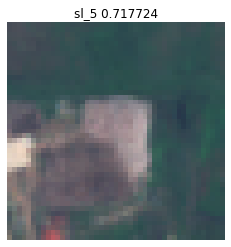

[0.10769232, 0.40774834]


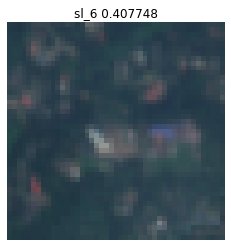

[0.6996993, 0.52638686, 0.8886064, 0.63806164, 0.84892595]


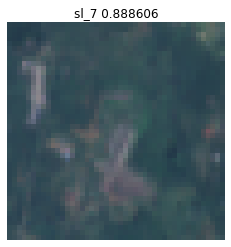

[0.9904062]


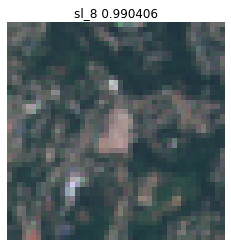

[0.4099855, 0.17822675, 0.95241374, 0.9218598]


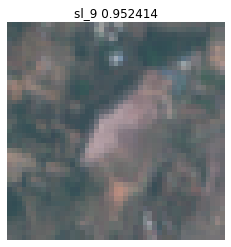

[0.35625955, 0.17439102, 0.9216273, 0.06244481, 0.0604579, 0.52934134]


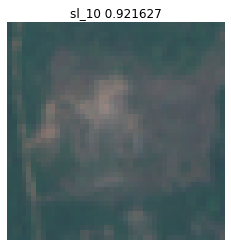

[2.0300052e-07, 0.0003130877, 2.1268694e-13]


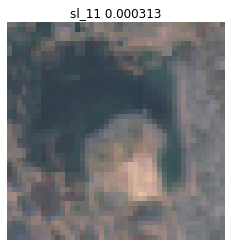

[0.9928082, 0.9714954, 0.6706845, 0.9875042]


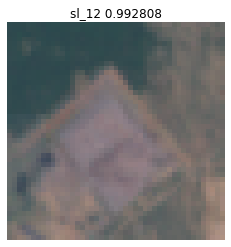

[0.9997062, 0.7022142, 0.99312085, 0.99985504]


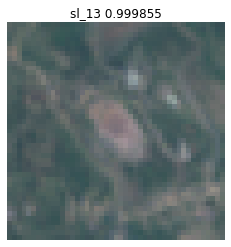

[0.008820618, 0.034212925, 0.8613412]


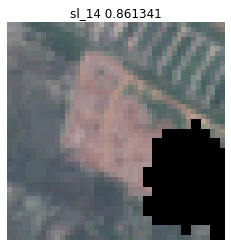

In [408]:
test_dataset = sri_lanka_data
#dates = list(test_dataset.keys())
#sites = list(test_dataset[dates[0]].keys())

threshold = -1
all_preds = []
filtered_candidates = []
for index, site in enumerate(sri_lanka_sites):
    preds = []
    rgb_stack = []
    for date in sri_lanka_dates:
        img = []
        band_shapes = [np.shape(test_dataset[date][site][band]) for band in band_descriptions]
        if np.array(band_shapes).all() > 0:
            for band in band_descriptions:
                img.append(normalize(test_dataset[date][site][band]))
            img = np.rollaxis(np.array(img), 0, 3)
            img = img[:model.input_shape[1], :model.input_shape[2], :]
            if np.mean(img) > 0:
                rgb = np.stack((img[:,:,3], img[:,:,2], img[:,:,1]), axis=-1)
                rgb_stack.append(rgb)
                preds.append(model.predict(np.expand_dims(img, 0))[0][1])
    if len(preds) > 0:
        all_preds.append([candidate_coords[index][1], candidate_coords[index][0], np.max(preds)])
        if np.median(preds) > threshold:
            print(preds)
            filtered_candidates.append([candidate_coords[index][1], candidate_coords[index][0], np.max(preds)])
            plt.imshow(np.clip(np.median(rgb_stack, axis=0), 0, 1))
            plt.axis('off')
            plt.title(f"{site} {np.max(preds):2f}")
            plt.show()

In [396]:
len(all_preds)

15